In [1]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
from scipy.stats import norm, kstest, sem, ttest_ind, linregress

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control


In [2]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"

In [3]:
def read_traces_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)
    return data_arr

def read_traces_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)
    return data_arr

def parse_date(subdir, long_year=False):
    try:
        char_select = -len('dd-mm-yyyy')
        subdir = subdir.replace("\\", "/")
        date = subdir.split("/")[-1][char_select:]
        date = [int(x) for x in date.split("-")]
        if long_year:
            date[2] = 2000 + date[2]
        date = "/".join([str(d) for d in date])
        return date
    except Exception as e:
        print(e, "could not process date from: ", subdir)
        return subdir

In [4]:
# read in final_df from merged data
roi_type = 'stripes'
merge_data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/"
merged_df = pd.read_csv(merge_data_dir + "merged_crossing_final_by_" + roi_type + ".csv", header=0)
merged_df

,Date,Slice_Loc,ROI,Value,Value_hw,Max_Amp_Time,Value_lat,Distance,Distance_Along_Barrel_Axis,Barrel,...,Stim_Distance1,Stim_Distance2,Slice,Loc,Is_Home_Barrel,Is_Lateral_Crossing,Animal,Litter,Is_Sagittal,Is_Rostral_Crossing
0,6/25/2024,3_1,1,0.000793,12.2953,53.250454,51.8526,28.460499,4.540766,1,...,187.693345,99.530659,3,1,0,0.0,6/25/2024,10,0,NaN
1,6/25/2024,3_1,2,0.000645,17.7750,59.247859,51.8450,32.202484,9.263163,1,...,187.693345,99.530659,3,1,0,0.0,6/25/2024,10,0,NaN
2,6/25/2024,3_1,3,0.000545,17.3931,54.749019,52.1832,38.626416,14.666674,1,...,187.693345,99.530659,3,1,0,0.0,6/25/2024,10,0,NaN
3,6/25/2024,3_1,4,0.000469,17.1436,59.751010,52.5067,44.598206,19.933963,1,...,187.693345,99.530659,3,1,0,0.0,6/25/2024,10,0,NaN
4,6/25/2024,3_1,5,0.000485,19.7282,61.246033,53.1831,46.486557,21.477824,1,...,187.693345,99.530659,3,1,0,0.0,6/25/2024,10,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,6/4/2024,4_2,3,0.001735,18.1069,57.749131,52.9676,43.046487,19.521720,2,...,181.137714,65.721297,4,2,0,NaN,6/4/2024,11,1,1.0
702,6/4/2024,4_2,4,0.001344,29.8651,59.750565,53.6190,47.042534,25.143976,2,...,181.137714,65.721297,4,2,0,NaN,6/4/2024,11,1,1.0
703,6/4/2024,4_2,5,0.001271,27.9799,61.748409,55.0954,51.351728,30.766231,2,...,181.137714,65.721297,4,2,0,NaN,6/4/2024,11,1,1.0
704,6/4/2024,4_2,6,0.001160,30.7221,64.250000,55.5781,53.935146,34.826749,2,...,181.137714,65.721297,4,2,0,NaN,6/4/2024,11,1,1.0



 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing\06-25-24
6/25/2024 3_1 1


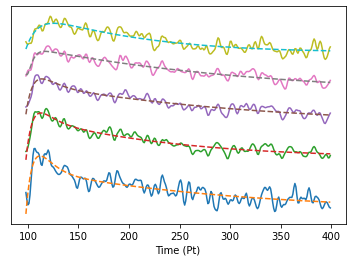

6/25/2024 3_1 2


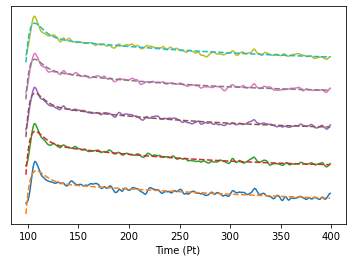

6/25/2024 3_1 3


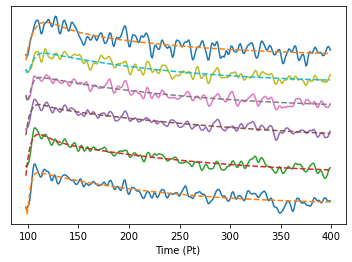

6/25/2024 3_2 1


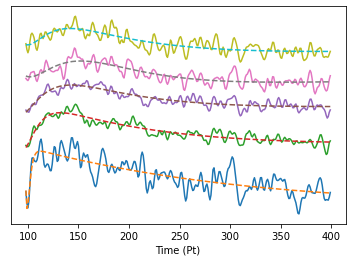

6/25/2024 3_2 2


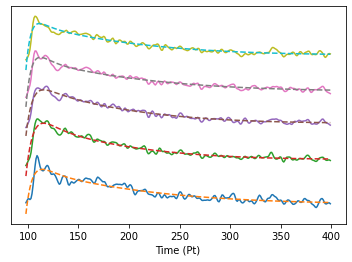

6/25/2024 3_2 3


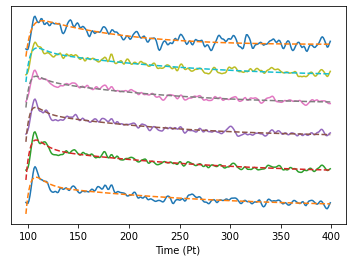

6/25/2024 3_3 1
Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.


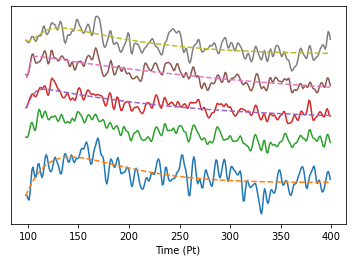

6/25/2024 3_3 2
6/25/2024 3_3 3
6/25/2024 3_4 1
6/25/2024 3_4 2
6/25/2024 3_4 3
6/25/2024 3_5 1
Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
6/25/2024 3_5 2
6/25/2024 3_5 3
6/25/2024 4_1 1
6/25/2024 4_1 2
6/25/2024 4_1 3
Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
6/25/2024 4_2 1
6/25/2024 4_2 2
Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
6/25/2024 4_2 3
6/25/2024 4_3 1
6/25/2024 4_3 2
6/25/2024 4_3 3
Error fitting functi

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


6/27/2024 1_2 3


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


6/27/2024 1_3 1
6/27/2024 1_3 2
6/27/2024 1_3 3


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


6/27/2024 2_1 1
6/27/2024 2_1 2
6/27/2024 2_1 3
6/27/2024 2_2 1
6/27/2024 2_2 2
6/27/2024 2_2 3


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


6/27/2024 2_3 1
6/27/2024 2_3 2
6/27/2024 2_3 3
Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
6/27/2024 6_1 1
Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
6/27/2024 6_1 2
6/27/2024 6_3 1
6/27/2024 6_3 2
6/27/2024 6_4 1
6/27/2024 6_4 2

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing\07-01-24
7/1/2024 1_1 1
7/1/2024 1_1 2
7/1/2024 1_2 1
7/1/2024 1_2 2
7/1/2024 2_1 1
7/1/2024 2_1 2
7/1/2024 2_2 1
7/1/2024 2_2 2
Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
7/1/2024 2_3 1
7/1/2024 2_3 2
7/1/2024 3_1 1
7/1/2024 3_1 2
7/1/2024 3_2 1
7/1/2024 3_2 2

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/coronal-crossing\07-03-24
7/3/2024 2_2 1
Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev =

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal\05-31-24
5/31/2024 1_1 1
Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
5/31/2024 1_1 2
5/31/2024 1_2 1
5/31/2024 1_2 2
5/31/2024 2_1 1
5/31/2024 2_1 2


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


5/31/2024 2_2 1
5/31/2024 2_2 2
5/31/2024 3_1 1
5/31/2024 3_1 2
5/31/2024 3_2 1
5/31/2024 3_2 2
5/31/2024 4_1 1
5/31/2024 4_1 2
5/31/2024 4_2 1
5/31/2024 4_2 2
5/31/2024 5_1 1
5/31/2024 5_1 2
5/31/2024 5_2 1
Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
5/31/2024 5_2 2

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal\06-03-24
6/3/2024 1_1 1
6/3/2024 1_1 2
6/3/2024 1_2 1
6/3/2024 1_2 2
6/3/2024 1_3 1
6/3/2024 1_3 2
6/3/2024 2_1 1
6/3/2024 2_1 2
6/3/2024 2_2 1
6/3/2024 2_2 2
6/3/2024 2_3 1
6/3/2024 2_3 2
6/3/2024 2_4 1
6/3/2024 2_4 2
6/3/2024 2_5 1
6/3/2024 2_5 2


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


6/3/2024 3_1 1
6/3/2024 3_1 2
6/3/2024 3_2 1
6/3/2024 3_2 2

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/sagittal\06-04-24
6/4/2024 3_1 1


c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Error fitting function to trace: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
6/4/2024 3_1 2
6/4/2024 3_2 1
6/4/2024 3_2 2
6/4/2024 4_1 1
6/4/2024 4_1 2
6/4/2024 4_2 1
6/4/2024 4_2 2
{'home': [0.8969449140794331, 0.950113561760228, 0.9459313384996151, 0.9023278255794155, 0.7774896526426324, 0.9179326968129258, 0.9004848906311982, 0.860967490868605, 0.8397705047562763, 0.7299819156736665, 0.45507637996880457, 0.5853185881062473, 0.5418889731318906, 0.9709917882593707, 0.9761924210182119, 0.9585071349184039, 0.9183290361121521, 0.9029735186877212, 0.6290860295600178, 0.8505209864033749, 0.8102822117609048, 0.7589961264528586, 0.791685568984978, 0.7768671187839599, 0.6693480210806266, 0.8810614148714905, 0.869151033970778, 0.8889592277402715, 0.8818119763445068, 0.8354104333708745, 0.8490651117988806, 0.8226759084457858, 0.6837755285678117, 0.3600549150529613, 0.5537223215260391, 0.6445025707990668, 0.5983089180012284, 0.5351108900843912, 0.24487033

In [5]:
data_map = {}
max_plots = 7
all_r_squared = {'home': [], 'neighbor': []}

for subdir, dirs, files in os.walk(data_dir):

    if not ('sagittal' in subdir or 'coronal' in subdir):
        continue
    if 'hidden' in subdir:
        continue
    if 'dic' in dirs and 'selected_zda' in dirs:
        print("\n", subdir)
        dic_dir = subdir + "/dic/"
        selected_zda_dir = subdir + "/selected_zda/"
        
        # optionally process date
        date = parse_date(subdir, long_year=True)

        # take selected zda and expand into separate subdir for each zda file
        for trace_file in os.listdir(subdir):
            if trace_file.endswith('.dat') and "trace_" in trace_file and ("_barrel_" + roi_type) in trace_file:
                # trace_filename = subdir + "/" + "trace_" + slic_loc_id + "_barrel_" + roi_type + str(i_barrel+1) + ".dat"
                trace_filename = subdir + "/" + trace_file


                # find out whether this barrel is home or neighbor
                barrel_id = int(trace_file.split(".")[0][-1])
                slice_loc_id = trace_file.split("trace_")[1][:3]
                print(date, slice_loc_id, barrel_id)
                subset_df = merged_df[(merged_df['Date'] == date) &
                                      (merged_df['Slice_Loc'] == slice_loc_id) & 
                                      (merged_df['Barrel'] == barrel_id)]
                is_home_barrel = (subset_df['Home_Barrel'].values[0] == 1)

                # read in the trace file
                traces = read_traces_file(trace_filename)
                tm = TraceMetrics(traces)

                #tm.show_traces()

                # apply alpha function fit and show the trace
                fit_metadata = tm.fit_trace_to_function('double_alpha', 
                                                        plot=(max_plots > 0),
                                                        measure_window=(98,400))
                for k in fit_metadata.keys():
                    if is_home_barrel:
                        all_r_squared['home'].append(fit_metadata[k][0])
                    else:
                        all_r_squared['neighbor'].append(fit_metadata[k][0])
                #[print(k, "\n\tR^2:", fit_metadata[k][0], "\n\tparameters:",
                #       fit_metadata[k][2]) for k in fit_metadata.keys()]

                max_plots -= 1

print(all_r_squared)
for k in all_r_squared.keys():
    print(k, "Mean R^2 value: ", np.mean(all_r_squared[k]), "+/-", np.std(all_r_squared[k]))

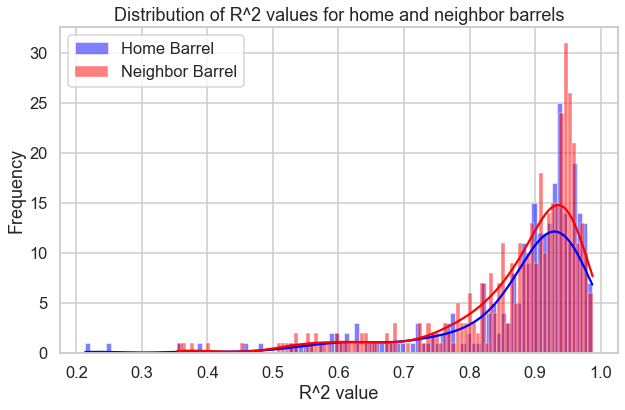

In [6]:
# plot distribution of R^2 values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("talk")
plt.figure(figsize=(10, 6))
sns.histplot(all_r_squared['home'], color='blue', bins=100, kde=True, label='Home Barrel')
sns.histplot(all_r_squared['neighbor'], color='red', bins=100, kde=True, label='Neighbor Barrel')
plt.xlabel("R^2 value")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of R^2 values for home and neighbor barrels")
plt.show()

## 